In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb
from scipy import stats

In [54]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')
cleaned_KC.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,zipcode,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,98178,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,98125,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,98028,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,98136,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,98074,1800,7503


In [55]:
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 15 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
yr_built         21534 non-null int64
zipcode          21534 non-null int64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(4), int64(10), object(1)
memory usage: 2.6+ MB


In [58]:
# stripping all cells with leading or trailing spaces
cleaned_KC = cleaned_KC.applymap(lambda x: x.strip() if type(x) == str else x)

In [59]:
index_id_KC = cleaned_KC.set_index(['id','date'])
index_id_KC.sort_values(by='id')

price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id         date                                                               
1000102    9/16/2014   280000.0         6       3.00         2400      9373   
           4/22/2015   300000.0         6       3.00         2400      9373   
1200019    5/8/2014    647500.0         4       1.75         2060     26036   
1200021    8/11/2014   400000.0         3       1.00         1460     43000   
2800031    4/1/2015    235000.0         3       1.00         1430      7599   
3600057    3/19/2015   402500.0         4       2.00         1650      3504   
3600072    3/30/2015   680000.0         4       2.75         2220      5310   
3800008    2/24/2015   178000.0         5       1.50         1990     18200   
5200087    7/9/2014    487000.0         4       2.50         2540      5001   
6200017    11/12/2014  281000.0         3       1.00         1340     21336   
7200080    11/4/2014   239000.0         4       2.00         1980     10585   
7200179    4/24/2015   175000.0         2       1.00          840     12750   
           10/16/2014  150000.0         2       1.00          840     12750   
7400062    5/21/2014   299800.0         2       1.00          790      5240   
7600057    8/5/2014    520000.0         3       2.00         1410      2700   
7600065    6/5/2014    465000.0         3       2.25         1530      1245   
7600125    12/18/2014  630000.0         5       1.00         3020      4800   
7600136    7/18/2014   411000.0         2       2.00         1130      1148   
9000025    12/3/2014   496000.0         2       1.00         1420      4635   
11200070   7/21/2014   570000.0         3       2.50         1530      3296   
11200290   6/9/2014    546000.0         3       2.50         1530      3464   
11200400   9/23/2014   617000.0         3       2.50         1910      4488   
11300120   6/30/2014   635000.0         3       2.50         3350      4007   
11500240   4/28/2015   872750.0         3       2.50         2870     13695   
11500890   3/12/2015   843000.0         3       2.50         3130      8750   
11501160   6/17/2014   837700.0         5       2.75         3010     12611   
11501310   11/21/2014  715000.0         3       3.25         3060      9055   
11501330   9/2/2014    795000.0         3       3.50         3190     10223   
11510310   9/5/2014    835000.0         4       2.75         3130     13412   
11510700   5/19/2014   755000.0         4       2.50         2660     10452   
...                         ...       ...        ...          ...       ...   
9834200925 9/10/2014   330000.0         3       2.25         1340      4080   
9834200950 6/16/2014   385000.0         4       1.75         1690      4080   
9834200975 2/10/2015   495000.0         3       3.00         1520      4080   
9834201100 12/22/2014  332500.0         4       2.00         1440      4855   
9834201145 2/22/2015   635000.0         4       2.50         2880      3091   
9834201205 3/4/2015    385000.0         1       1.00          620      5100   
9834201215 10/9/2014   276000.0         2       1.00          870      2676   
9834201366 12/16/2014  429900.0         3       2.00         1490      1286   
9834201367 1/26/2015   429000.0         3       2.00         1490      1126   
9834201370 4/17/2015   430100.0         3       2.25         1400      1078   
9834201375 2/6/2015    425000.0         3       2.25         1420      1230   
9834201470 12/18/2014  303000.0         2       1.50         1000      1075   
9835800320 8/28/2014   300000.0         4       1.75         2080      8750   
9835800750 12/3/2014   247000.0         3       2.25         1640      7630   
9835800840 2/4/2015    215000.0         4       2.00         1470      7000   
9835801000 6/25/2014   245700.0         3       2.25         1640      8400   
9839300125 1/7/2015    575000.0         4       2.00         1810      4400   
9839300285 4/12/2015   720000.0         3       2.50         2100      2200 

In [60]:
mean_of_price = cleaned_KC['price'].mean()
mean_of_price

540057.663833937

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a36305cc0>,
      dtype=object)

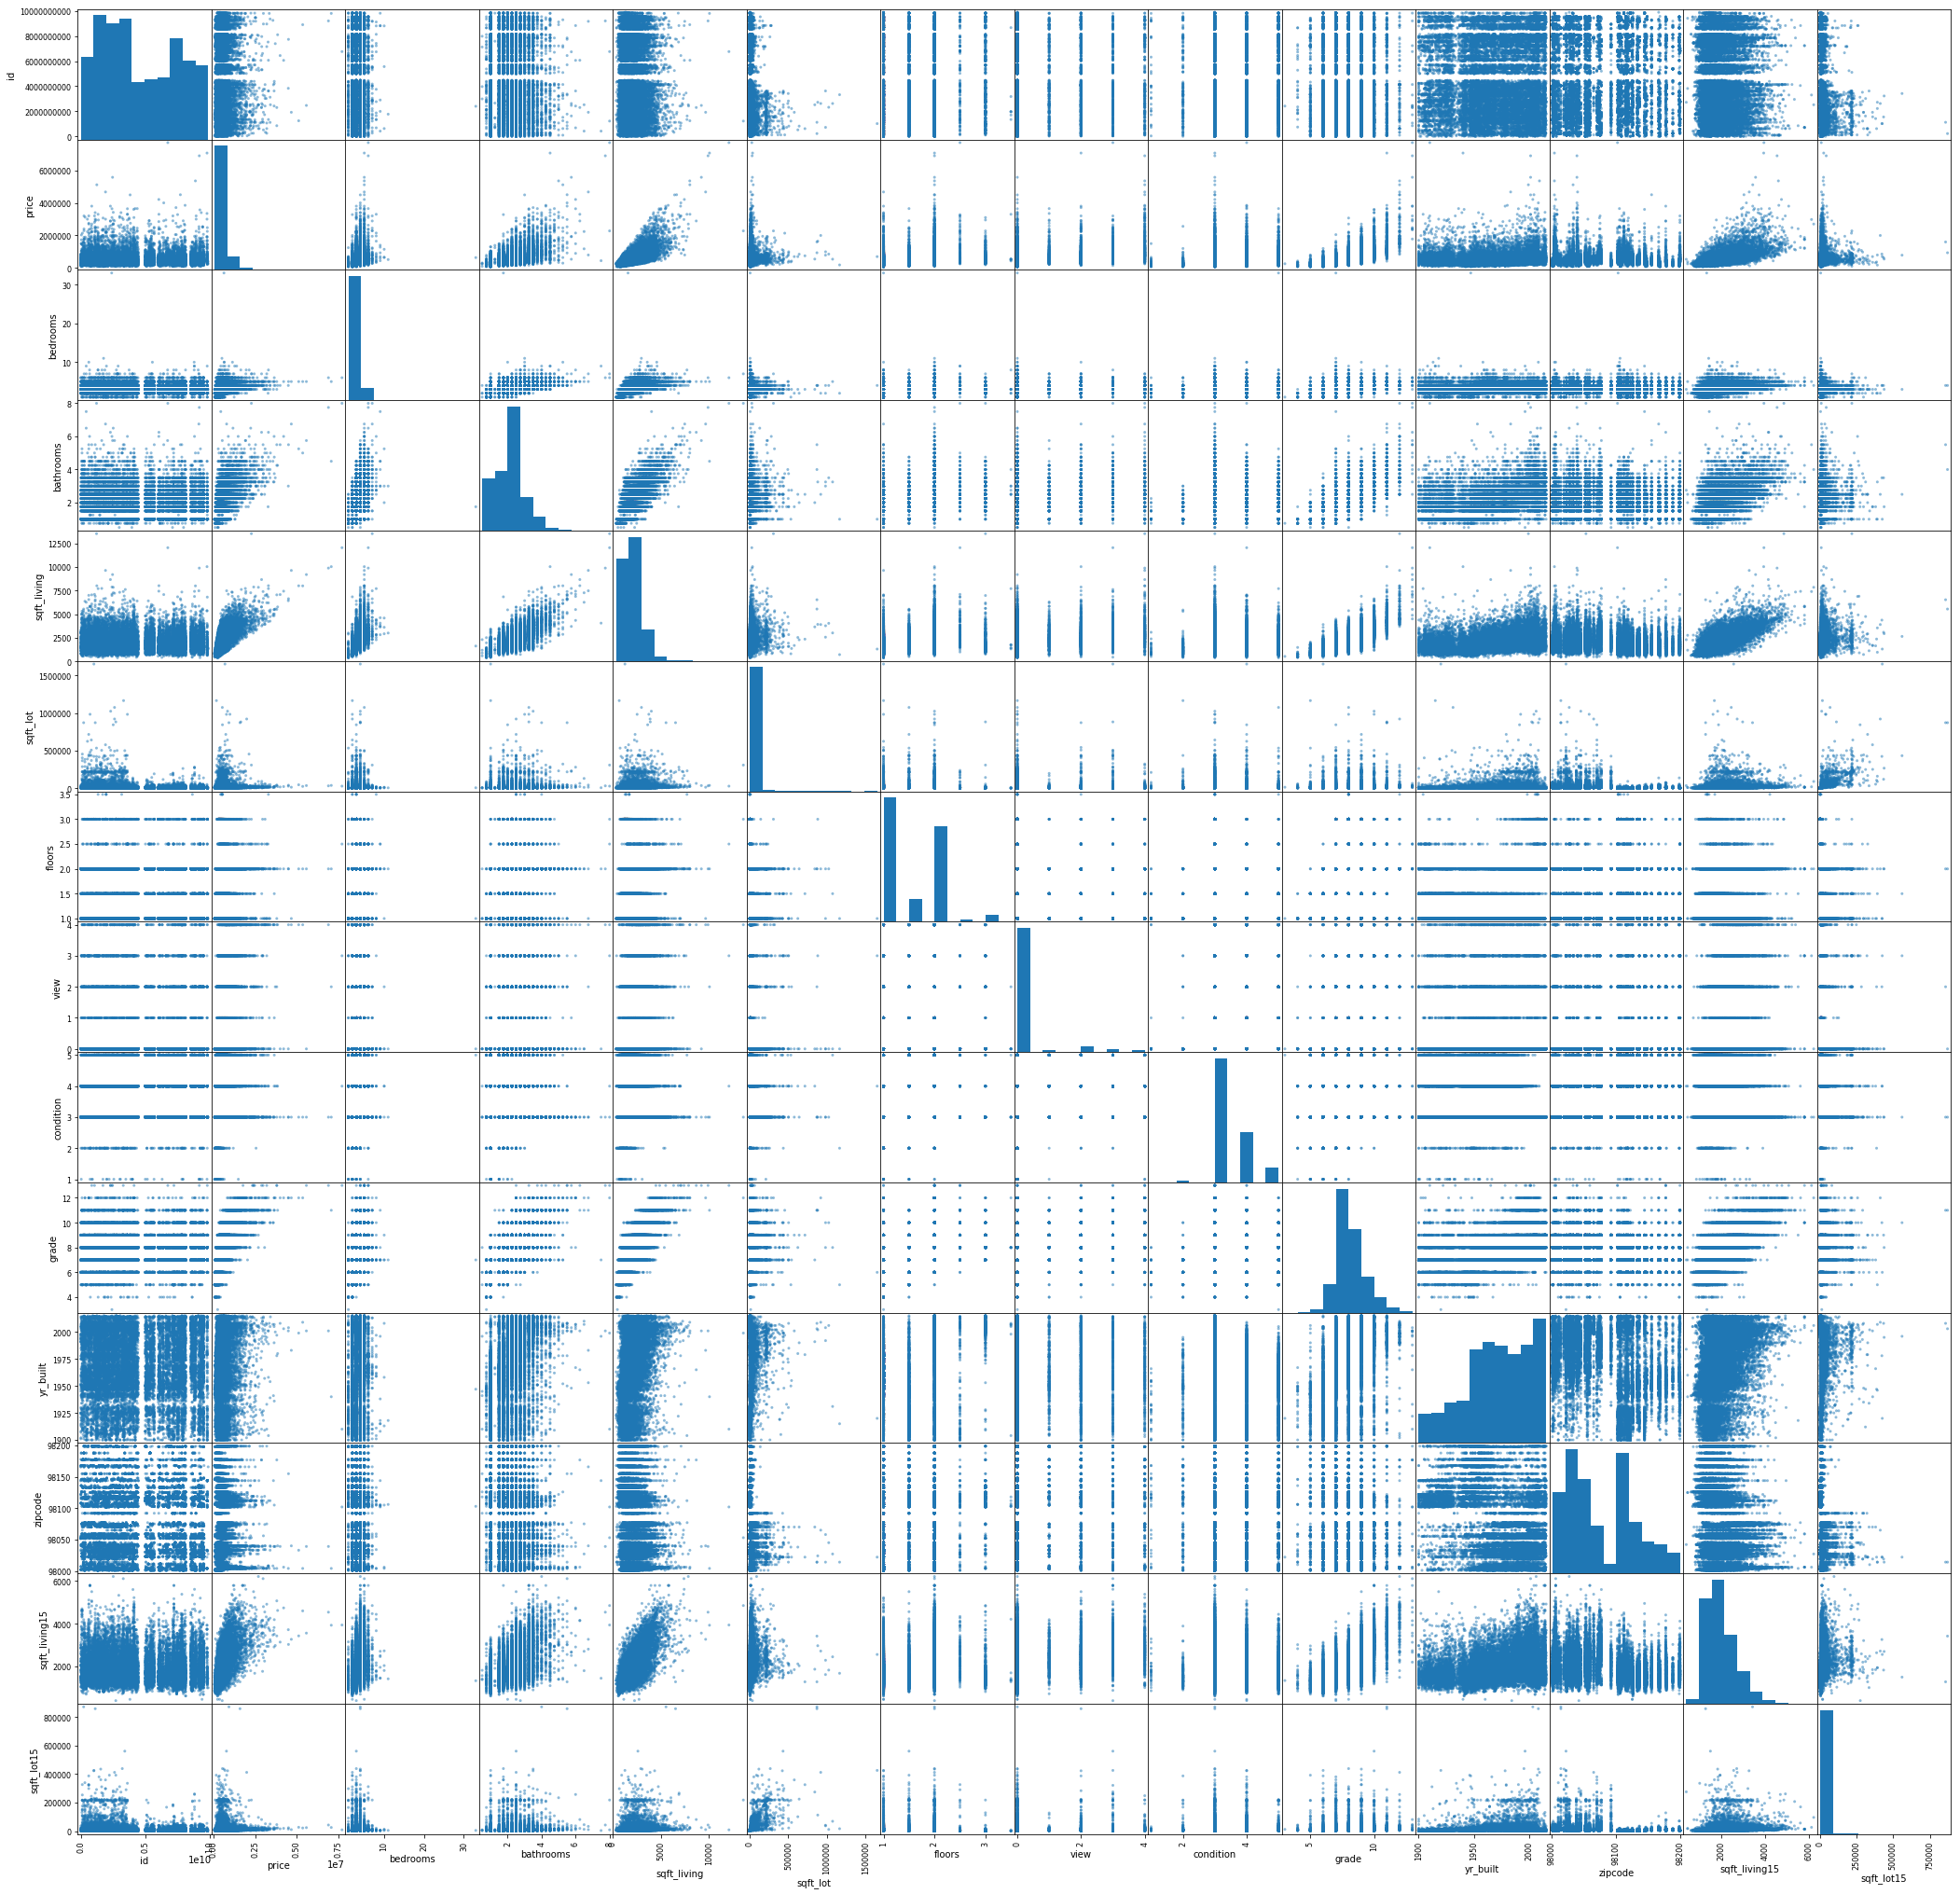

In [61]:
pd.plotting.scatter_matrix(cleaned_KC,alpha=0.5,figsize=(36,36))

sqft_living has a positive correlation with price
bathrooms has a positive correlation with price
sqft_living15 has a positive correlation with price

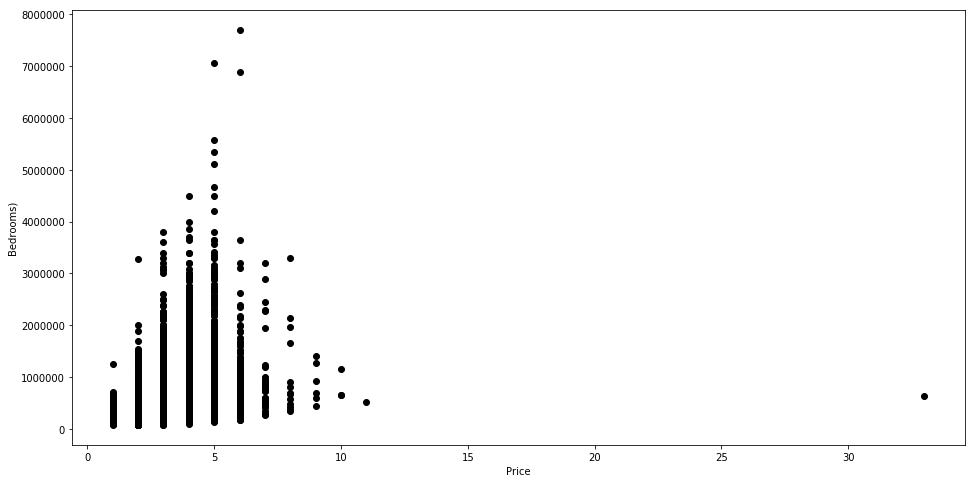

In [64]:
plt.figure(figsize=(16, 8))
plt.scatter(
    cleaned_KC['bedrooms'],
    cleaned_KC['price'],
    c='black'
)
plt.xlabel("Price")
plt.ylabel("Bedrooms)")
plt.show()